In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


사전 자료 로드

In [2]:
# 20

# boston 데이터셋 로드
boston= pd.read_csv("C:/apps/ml_7/datasets/Boston.csv", index_col=0)

# boston dataset의 target array는 주택 가격
y_target = boston['medv']
X_data = boston.drop('medv', axis=1)

# print(boston.shape)
# boston.head()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# Pipeline 객체로 streamline 하게 Polynomial Feature변환과 Linear Regression을 연결
p_model = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)), ('linear', LinearRegression())])

p_model
# 파이프라인 구축
Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('Linear', 
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None))],
        verbose=False)

p_model.fit(X_train, y_train)
y_preds = p_model.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

# print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
# print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))


p_model = Pipeline([('poly', PolynomialFeatures(degree=3, include_bias=False)),
                    ('linear', LinearRegression())])

p_model.fit(X_train, y_train)
y_preds = p_model.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

# print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
# print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

In [3]:
#  앞의 LinearRegression예제에서 분할한 feature 데이터 셋인 X_data과 Target 데이터 셋인 y_target 데이터 셋을 그대로 이용
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [4]:
# 21

from sklearn.linear_model import Lasso, ElasticNet

# alpha 값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고, 회귀계수 값들을 DF로 반환해주는 함수

def get_linear_reg_eval(model_name, params = None, X_data_n = None, y_target_n = None, verbose = True) :
    coeff_df = pd.DataFrame()

    if verbose : print ('####### ', model_name , '#######')

    for param in params :
        if model_name == 'Ridge' : model = Ridge(alpha=param)
        elif model_name == 'Lasso' : model = Lasso(alpha=param)
        elif model_name == 'ElasticNet' : model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring="neg_mean_squared_error", cv=5)
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        
        print(f'alpha {param}일 때 5 폴드 세트의 평균 RSME : {avg_rmse:.3f}')


        # cross_cal_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(X_data, y_target)

        # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DF의 컬럼으로 추가
        coeff = pd.Series(data=model.coef_, index=X_data.columns)
        colname = 'alpha : ' + str(param)
        coeff_df[colname] = coeff

    return coeff_df

# end of get_linear_reg_eval

### 피처 데이터 변환에 따른 예측 성능 비교 실습

타겟값은 비교적 정규화가 잘 되어 있다. 피처값만 정규화를 해주면 된다

(506,)


(array([ 21.,  55.,  82., 154.,  84.,  41.,  30.,   8.,  10.,  21.]),
 array([ 5. ,  9.5, 14. , 18.5, 23. , 27.5, 32. , 36.5, 41. , 45.5, 50. ]),
 <BarContainer object of 10 artists>)

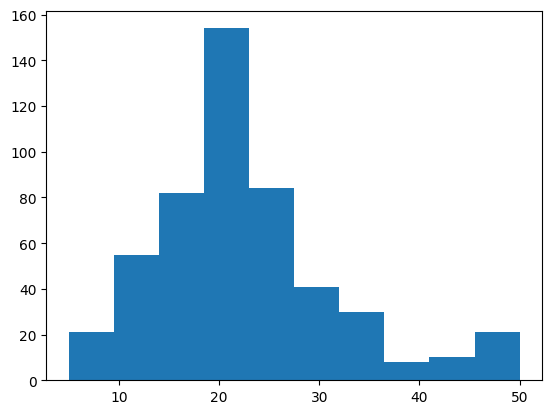

In [5]:
print(y_target.shape)
plt.hist(y_target, bins=10)

데이터 전처리 (정규화, 로그변환)을 해주는 함수 정의

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환 (Standard), 최대값/최소값 정규화 (MinMax), 로그변환 (Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용
# p_degree는 2이상 부여하지 않음

def get_scaled_data(method='None', p_degree=None, input_data=None) :

    if method == 'Standard' :
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax' :
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log' :
        scaled_data = np.log1p(input_data)
    else :
        scaled_data = input_data


    if p_degree != None :
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

    return scaled_data

결론

In [7]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

# 변환 방법은 모두 6개, 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성, 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods = [(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods :
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
    print(f'\n## 변환 유형 : {scale_method[0]}, Polynomial Degree : {scale_method[1]}')

    # alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고, 회귀 계수값들을 DF로 반환해주는 함수
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False)


## 변환 유형 : None, Polynomial Degree : None
alpha 0.1일 때 5 폴드 세트의 평균 RSME : 5.788
alpha 1일 때 5 폴드 세트의 평균 RSME : 5.653
alpha 10일 때 5 폴드 세트의 평균 RSME : 5.518
alpha 100일 때 5 폴드 세트의 평균 RSME : 5.330

## 변환 유형 : Standard, Polynomial Degree : None
alpha 0.1일 때 5 폴드 세트의 평균 RSME : 5.826
alpha 1일 때 5 폴드 세트의 평균 RSME : 5.803
alpha 10일 때 5 폴드 세트의 평균 RSME : 5.637
alpha 100일 때 5 폴드 세트의 평균 RSME : 5.421

## 변환 유형 : Standard, Polynomial Degree : 2
alpha 0.1일 때 5 폴드 세트의 평균 RSME : 8.827
alpha 1일 때 5 폴드 세트의 평균 RSME : 6.871
alpha 10일 때 5 폴드 세트의 평균 RSME : 5.485
alpha 100일 때 5 폴드 세트의 평균 RSME : 4.634

## 변환 유형 : MinMax, Polynomial Degree : None
alpha 0.1일 때 5 폴드 세트의 평균 RSME : 5.764
alpha 1일 때 5 폴드 세트의 평균 RSME : 5.465
alpha 10일 때 5 폴드 세트의 평균 RSME : 5.754
alpha 100일 때 5 폴드 세트의 평균 RSME : 7.635

## 변환 유형 : MinMax, Polynomial Degree : 2
alpha 0.1일 때 5 폴드 세트의 평균 RSME : 5.298
alpha 1일 때 5 폴드 세트의 평균 RSME : 4.323
alpha 10일 때 5 폴드 세트의 평균 RSME : 5.185
alpha 100일 때 5 폴드 세트의 평균 RSME : 6.538

## 변환 유형 : Log, Polynomial Degree